**Kate Groschner** <br>
**AY250 Homework 6**

In [83]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skimage 
from skimage import io
from skimage.color import rgb2gray
import os
import skimage.feature
import skimage.filters
import skimage.color
from skimage.util import invert
from skimage.morphology import skeletonize
from scipy.signal import correlate2d
import pandas as pd
import cv2
from pathlib import Path
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
import logging
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Question 1

** Feature Creation ** <br>
Fifteen feature Classes were made. Some of these feature classes actually output multiple features. Several feature classes actually output 10 bin histograms so while it is one feature class the random forest generator will actually see this as 10 seperate classes. A few of the feature classes have combined functions but the doc strings should make what each feature is clear.

In [2]:
#defining functions to output all of the features in 1D numpy arrays
def avg_red(img):
    """returns average value of red channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,0].mean()]
    return np.array(avg)

def avg_blue(img):
    """returns average value of blue channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,1].mean()]
    return np.array(avg)

def avg_green(img):
    """returns average value of green channel"""
    if len(img.shape) != 3:
        img = skimage.color.gray2rgb(img)
    avg = [img[:,:,2].mean()]
    return np.array(avg)

# edges from sobel
def sobel_edges(gray_image):
    """Returns histogram of edges"""
    edges = skimage.filters.sobel(gray_image)
    edge_hist = np.histogram(edges,bins=10, density = True)[0]
    return edge_hist

# number of blobs from difference of gaussian
def blobs_dog(gray_image):
    """returns two features: average blob size and total number of blobs detected by difference of gaussians"""
    blob = skimage.feature.blob_dog(gray_image, max_sigma=50, threshold=.1)
    blobs = blob[:,2]
    num_blobs = len(blobs)
    if num_blobs == 0:
        avg_blob = 0
    else:
        avg_blob = blobs.mean()
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def blobs_log(gray_image):
    """returns two features: average blob size and total number of blobs detected by laplace of gaussians"""
    blob = skimage.feature.blob_log(gray_image, max_sigma=5, num_sigma=10, threshold=.1)
    blobs = blob[:,2]
    num_blobs = len(blobs)
    if num_blobs == 0:
        avg_blob = 0
    else:
        avg_blob = blobs.mean()
    blob_info = np.array([avg_blob, num_blobs])
    return blob_info

def fft_hist(gray_image):
    """returns 10 bin histogram of frequencies from fft of image"""
    fft = np.log2(abs(np.fft.rfft2(gray_image)))
    fhist = np.histogram(fft,bins=10,density = True)[0]
    return fhist

def lbp_hist(gray_image):
    """returns 10 bin histogram of local binary patterns from image"""
    lbp = skimage.feature.local_binary_pattern(gray_image,30,30)
    lhist = np.histogram(lbp,bins=10,density = True)[0]
    return lhist

def center_cut(image):
    """returns a 1d array of length 48 which is 4x4 center of image of all three channels flattened"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    middle = (image.shape[0]//2,image.shape[1]//2)
    cut = image[(middle[0]-2):(middle[0]+2),(middle[1]-2):(middle[1]+2),:].flatten()
    return cut

def avg_HSV(image):
    """returns the average for hue, saturation, and value from image"""
    if len(image.shape) == 3:
        img_out = skimage.color.rgb2hsv(image)
    else:
        img_out = skimage.color.rgb2hsv(skimage.color.grey2rgb(image))
    h = img_out[:,:,0].mean()
    s = img_out[:,:,1].mean()
    v = img_out[:,:,2].mean()
    results = [h,s,v]
    if np.nan in results:
        print(file)
    return np.array(results)

def sift10(image):
    """returns 1d array of length 10 which represents the first 10 SIFT features of the image"""
    if len(image.shape) != 3:
        image = skimage.color.gray2rgb(image)
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(image,None)
    if des.shape[0] <= 10:
        dif = 10 - des.shape[0]
        filler = np.zeros((dif,128))
        sift = np.concatenate((des,filler),axis=0).flatten()
    else:
        sift = des[:10,:].flatten()
    sift_hist= np.histogram(sift,bins=10, density = True)[0]
    return sift_hist

def color_hist(image):
    """returns 1d array of length 30 representing the color histogram for red,blue, and green channels"""
    hist = []
    if len(image.shape) == 3:
        for i in range(0,3):
            hist.append(np.histogram(image[:,:,i],bins=10, density = True)[0])
    else:
        for i in range(0,3):
            hist.append(np.histogram(image,bins=10, density = True)[0])
    hist = np.concatenate(hist)
    return hist

def image_properties(image):
    """Returns a 1d array of length 3, containing the width, height, and number of pixels in the image"""
    number_pixels = image.shape[0]*image.shape[1]
    properties = np.array([image.shape[0],image.shape[1],number_pixels])
    return properties

def get_features(file):
    """Function takes in a file name from list of files, opens it, creates a gray version for features which require
    gray image and then creates a list of features as well as a label which is then returned"""
    image = io.imread(file)
    label = file.parent.name
    gray_image = rgb2gray(image)
    features = [] 
    features.append(color_hist(image))
    features.append(sift10(image))
    features.append(avg_HSV(image))
    features.append(center_cut(image))
    features.append(lbp_hist(gray_image))
    features.append(fft_hist(gray_image))
    features.append(blobs_log(gray_image))
    features.append(blobs_dog(gray_image))
    features.append(sobel_edges(gray_image))
    features.append(avg_green(image))
    features.append(avg_blue(image))
    features.append(avg_red(image))
    features.append(image_properties(image))
    features = np.concatenate(features)
    return (features,label)


## Question 2

For question 2, I first wrote a function to create a pandas dataframe based on the list of features calculated for each image. This is then followed by functions to split the data, and then a function to train a random forest classifier. After that several functions for model validation and optimization follow. After that I included demos of all the functions and discussion of the performance of the model.

In [109]:
def feature_frame(directory, validation = False):
    """Creates a pandas dataframe with all the calculated features for all the images in a given directory. 
    The validation keyword just specifies whether the images are all in one file (validation = True) 
    or separate files (validation = False)."""
    if validation == False:
        files = list(Path(directory).glob('*/*.jpg'))
    else:
        files = list(Path(directory).glob('*.jpg'))
    features = Parallel(n_jobs=-1)(delayed(get_features)(file) for file in tqdm(files))
    print('Done!')
    feat_list, labels_list = zip(*features)
    df = pd.DataFrame.from_records(feat_list)
    column_names = [['color_hist']*30,['sift10']*10,['avg_HSV']*3,['center_cut']*48,['lbp_hist']*10,\
                    ['fft_hist']*10,['blobs_log']*2,['blobs_dog']*2,['sobel_edges']*10,['avg_green'],['avg_blue'],\
                    ['avg_red'],['height'],['width'],['number_pixels']]
    column_names = sum(column_names, [])
    df.columns = column_names
    df['Label'] = labels_list
    return df

In [112]:
#For breaking up the training and test sets I decided to under sample for the training set because 
#some classes had many more samples than others and if I just randomly shuffled the data and split it 
#the model trained to these classes, particularly the airplane class
def train_test_set(directory):
    """outputs the full feature dataframe, training and test sets given a directory of directories of images"""
    df = feature_frame(directory)
    csv_name = directory + '/featuresFinal.csv'
    df.to_csv(csv_name)
    X_train, Y_train, X_test, Y_test = split_set(df)
    return df, X_train, Y_train, X_test, Y_test
    
def split_set(df):
    """splits a feature data frame into test and training sets"""
    train_set = pd.DataFrame(columns=df.columns.values)
    test_set = pd.DataFrame(columns=df.columns.values)
    names_list = df['Label'].drop_duplicates()
    for name in names_list:
        temp = df[df.values == name]
        train_set=train_set.append(temp.iloc[:40,:])
        test_set=test_set.append(temp.iloc[40:,:])
    train_set = shuffle(train_set, random_state=0)
    test_set = shuffle(test_set, random_state=0)
    X_train = train_set.iloc[:,:-1]
    Y_train = train_set.iloc[:,-1]
    X_test = test_set.iloc[:,:-1]
    Y_test = test_set.iloc[:,-1]
    return X_train, Y_train, X_test, Y_test

In [16]:
def train_random_forest(X_train, Y_train, nestimators = 50,crit='gini',max_feat='auto'):
    """function that takes in the training feature set and training labels and trains a radnom forest with 
    n estimators given by nestimators"""
    classifier = RandomForestClassifier(n_estimators= nestimators,criterion= crit,max_features=max_feat)
    classifier.fit(X_train, Y_train)
    return classifier

In [139]:
def optimize_model(X_train,Y_train, nestimators = [10,20,30,50,70,100]):
    """function which runs model optimization given a certain number of n_estimators, max_features, and criterion
    (gini or entropy)"""
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    parameters = {'n_estimators':nestimators,  'max_features':[3,8,10,'auto'], 
                 'criterion': ['gini','entropy']}
    rf_tune = model_selection.GridSearchCV(RandomForestClassifier(), parameters, 
                                       n_jobs = -1, cv = 5,verbose=1)
    rf_opt = rf_tune.fit(X_train, Y_train)
    print("Best zero-one score: " + str(rf_opt.best_score_) + "\n")
    print("Optimal Model:\n" + str(rf_opt.best_estimator_))
    return rf_opt

In [132]:
def cross_val_stratified(features_df,model,nsplit):
    """runs stratified k-fold cross validation where nsplit specifies the number of splits
    and returns the mean and standard deviation of the cross validation score. Based on the code shown in 
    class."""
    X = features_df.iloc[:,:-1]
    Y = features_df.iloc[:,-1]
    cv = StratifiedKFold(n_splits=nsplit)
    scores = cross_val_score(model, X, Y, cv=cv, n_jobs=-1)
    print("mean: {:3f}, stdev: {:3f}".format(
        np.mean(scores), np.std(scores)))

In [105]:
def feature_importance(X_train,classifier):
    """Makes a plot of feature importance based of the feature importances calculated by scikit learn.
    Obviously features such as historgrams actually go into the classifier as several features so the function
    adds the importances of each of the features belonging to a certain class of feature"""
    feat_importance = np.vstack((X_train.columns.values,classifier.feature_importances_))
    previous = feat_importance[0,0]
    classes = [previous]
    counts = []
    temp_count = 0
    for idx, classify in enumerate(feat_importance[0,:]):
        if classify == previous:
            temp_count += feat_importance[1,idx]
            previous = classify
        else:
            counts.append(temp_count)
            classes.append(classify)
            temp_count = 0
            temp_count += feat_importance[1,idx]
            previous = classify

    counts.append(temp_count)
    fig, ax = plt.subplots()
    plt.bar(np.arange(1,len(classes)+1),counts,tick_label = classes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(80)
    ax.set_xlabel('Feature Class')
    ax.set_ylabel('Feature Importance')
    ax.set_title("Feature Importance vs Feature Class")

In [128]:
def plot_confusion_matrix(X, Y, df, model):
    """Creates a confusion matrix for the different classes given a set of features, true labels, the dataset
    and the desired trained classfier"""
    Y_pred = model.predict(X)
    Y_labels = df['Label'].drop_duplicates()
    cfm = confusion_matrix(Y, Y_pred, labels=Y_labels)
    df_cfm = pd.DataFrame(data = cfm, columns=Y_labels, index=Y_labels)
    plt.subplots(figsize=(20,15))
    ax = sns.heatmap(df_cfm, vmax = 90, annot=True, fmt="d")

In [31]:
model = train_random_forest(X_train,Y_train)

In [11]:
directory = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories'
df, X_train, Y_train, X_test, Y_test = train_test_set(directory)

100%|██████████| 4244/4244 [1:21:00<00:00,  1.15s/it]


Done!


** Testing a basic random forest with 50 trees **

In [113]:
X_train, Y_train, X_test, Y_test = split_set(df)

In [117]:
#training the basic model
model = train_random_forest(X_train,Y_train)

In [118]:
#getting the cross validation score for the basic model
cross_val_stratified(df,model,5)

mean: 0.296031, stdev: 0.009885


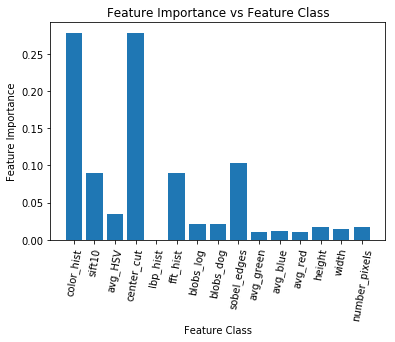

In [121]:
#seeing which features are the most important
feature_importance(X_train,model)

** Optimizing the model **

In [140]:
rf_opt= optimize_model(X_train,Y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.3min finished


Best zero-one score: 0.2175

Optimal Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


** Creating a model to match the optimized conditions and training it: **

In [141]:
#creating optimized model
opt_model = train_random_forest(X_train,Y_train,100, max_feat=8)

In [142]:
#calculating cross validation score for optimized model
cross_val_stratified(df,opt_model,5)

mean: 0.299242, stdev: 0.006473


** Discussion of Cross Validation Score ** <br>
The mean cross validation score shows the model has an accuracy of 29.9% with a standard deviation of 0.6%. Clearly this is not a perfect model, but given that selecting a class at random would have a 2% chance (or 1/50) the model is doing significantly better than random chance. 

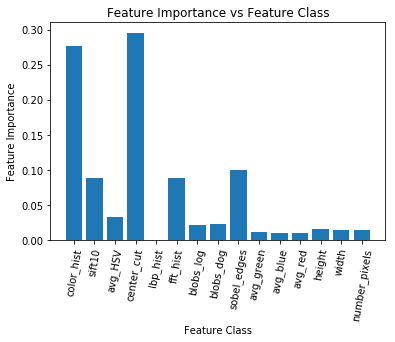

In [143]:
#Plotting feature importance
feature_importance(X_train,opt_model)

** Discussion of Feature Importance ** <br>
The top three features were clearly the color histogram and the 4x4 center cut of the image followed by the sobel edge histogram. Close in importance to the sobel edge histogram was the first ten SIFT features as well as the histogram of frequencies in the image, calculated via fft. I suspect that the shear number of actual features for both color histogram and center cut contributed to its importance. If the sum of importance was divided by the number of actual input features for each the order of feature importance may have been different. However, it is not too suprising that information on edges, SIFT features, and frequencies were also very important. Local binary patterns seem to have not contributed at all, which may indicate a problem with the implmentation of local binary patterns.

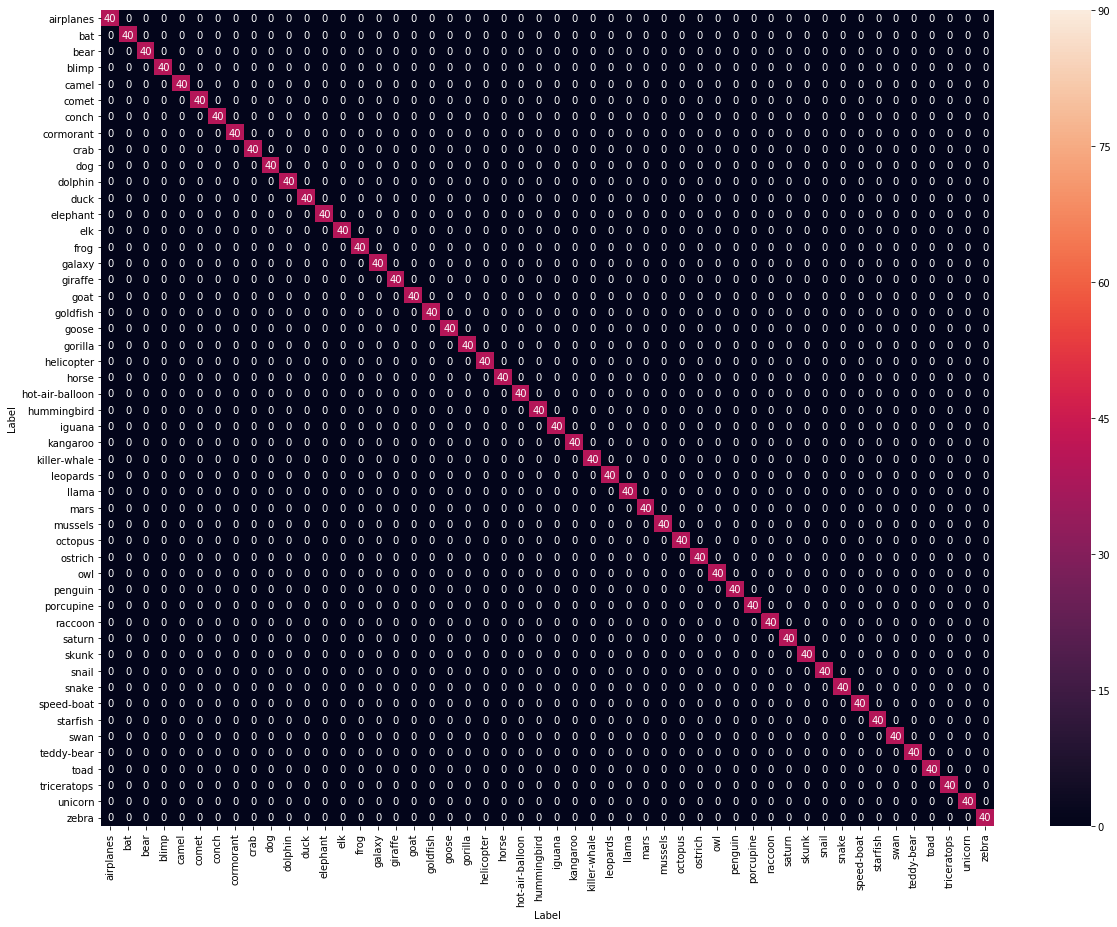

In [144]:
plot_confusion_matrix(X_train, Y_train, df, opt_model)

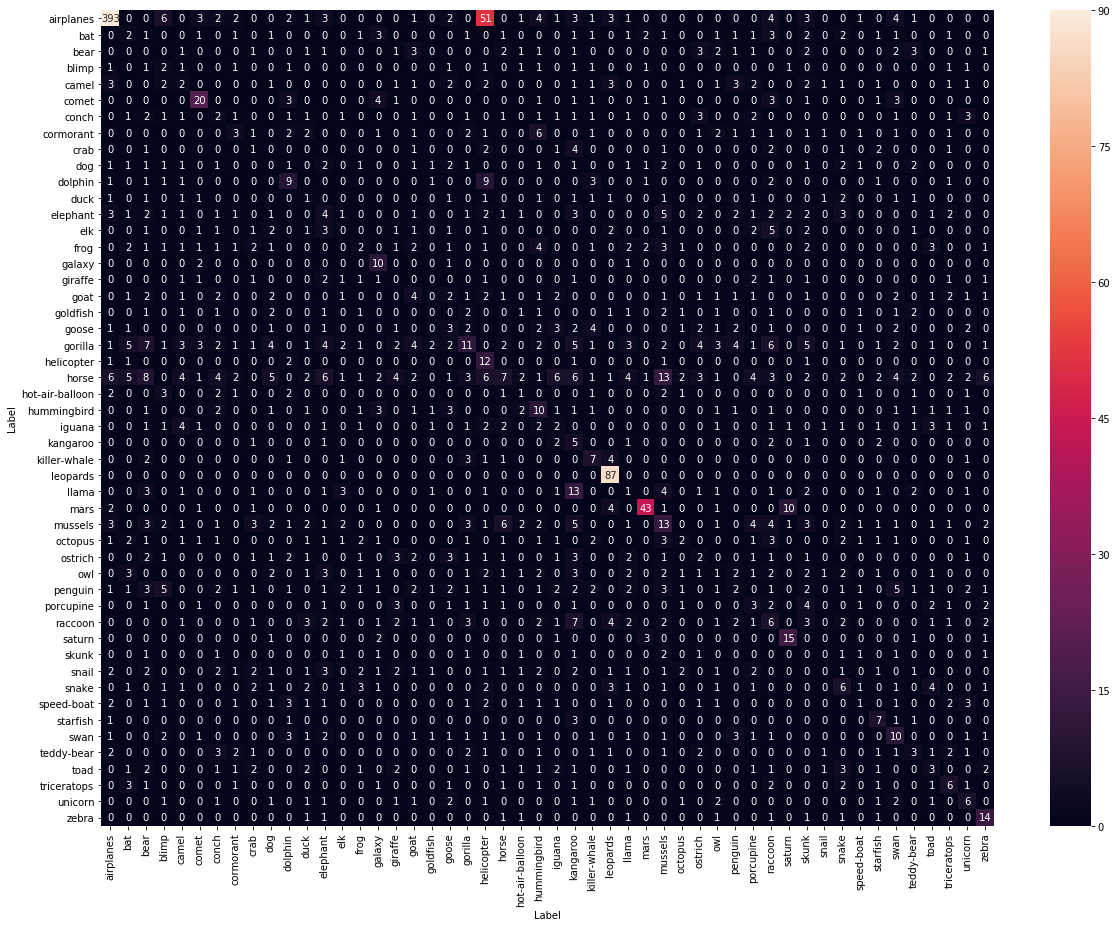

In [145]:
plot_confusion_matrix(X_test, Y_test, df, opt_model)

** Discussion of Confusion Matrices ** <br>
It is likely that when the model is training it is overfitting because on the training data the model is fitting perfectly and on the test data it is not doing as well. I tried removing trees to fix this problem however, that only lead to a reduction in performance and the model still had this same appearance of overfitting. Therefore I decided to keep this model. It is slightly hard to tell exactly how well the model is doing on the test data using the confusion matrix because the test data set is very unbalanced. While the training data set was undersampled all of the left over data was sent to the test data set which in turn was very unbalanced as can be seen in the score for airplanes. Most serious misassignments generally make sense - airplanes were confused for helicopters several times, mars was confused for saturn. I think improvements could likely be made by reducing the number of features related to color and increasing the number of features dealing with texture or maybe introducing Haar like features.

In [148]:
#saving optimized model for use in run_final_classifier
joblib.dump(opt_model, 'optimized_model.pkl')

['optimized_model.pkl']

## Question 3

In [108]:
def run_final_classifier(directory):
    """Run final classifier opens the saved optimized model, calculates the features of the images in a given 
    directory, which should conatin a slash at the end, and then predicts the class and outputs the image filename 
    and predicted class into validation_predictions.txt. The results are also printed in the notebook."""
    model = joblib.load('optimized_model.pkl')
    df = feature_frame(directory,True)
    predictions = model.predict(df.iloc[:,:-1])
    files = list(Path(directory).glob('*.jpg'))
    label_file = open('validation_predictions.txt', "r+")
    label_file.truncate()
    label_file.write("filename"+"\t"+"\t"+"predicted_class"+"\n")
    line = len("filename"+"\t"+"predicted_class")*"_ "
    label_file.write(line+"\n")
    for idx, predict in enumerate(predictions):
        label_file.write(files[idx].parts[-1] + "\t"+"\t"+ predict +"\n")
    label_file.close()
    label_file = open('validation_predictions.txt', "r")
    file_lines = label_file.readlines()
    for lines in file_lines:
        print(lines)
    label_file.close()

In [147]:
#test run using one of the files of images from the test and training set
directory2 = '/Users/kategroschner/Documents/Berkeley2017_2018/AY250/python-ay250-homework/hw_6/50_categories/comet/'
run_final_classifier(directory2)

100%|██████████| 81/81 [00:30<00:00,  2.63it/s]


Done!
filename		predicted_class

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

comet_0001.jpg		comet

comet_0002.jpg		comet

comet_0003.jpg		comet

comet_0004.jpg		comet

comet_0005.jpg		comet

comet_0006.jpg		comet

comet_0007.jpg		comet

comet_0008.jpg		comet

comet_0009.jpg		comet

comet_0010.jpg		comet

comet_0011.jpg		comet

comet_0012.jpg		comet

comet_0013.jpg		comet

comet_0014.jpg		comet

comet_0015.jpg		comet

comet_0016.jpg		comet

comet_0017.jpg		comet

comet_0018.jpg		comet

comet_0019.jpg		comet

comet_0020.jpg		comet

comet_0021.jpg		comet

comet_0022.jpg		comet

comet_0023.jpg		comet

comet_0024.jpg		comet

comet_0025.jpg		comet

comet_0026.jpg		comet

comet_0027.jpg		comet

comet_0028.jpg		comet

comet_0029.jpg		comet

comet_0030.jpg		comet

comet_0031.jpg		comet

comet_0032.jpg		comet

comet_0033.jpg		comet

comet_0034.jpg		comet

comet_0035.jpg		comet

comet_0036.jpg		comet

comet_0037.jpg		comet

comet_0038.jpg		comet

comet_0039.jpg		comet

comet_0040.jpg		come